import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [26]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import pandas as pd
import numpy as np
from numpy import savetxt
from functions import *
from IPython.display import Image
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
arena_df = pd.read_csv("data/arenas_w_locations.csv", index_col=0)
arena_gdf = gpd.GeoDataFrame(
            arena_df, geometry=gpd.points_from_xy(arena_df.Lng, arena_df.Lat))
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson")

## Data Engineering

In [10]:
# just arena coords
arena_coords = arena_df[['Team_name', 'Lat', 'Lng']]

# Clustergram

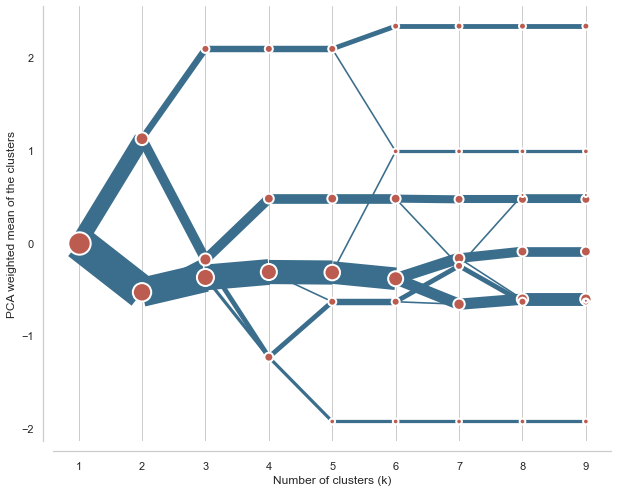

In [11]:
data = scale(arena_coords.drop(columns=['Team_name']))
cgram = fit_plot_clustergram(data)

## Analyzing the optimal number of clusters

In [12]:
evaluate_num_of_clusters(cgram)

(array([[0.39722038],
        [1.37127715],
        [1.73930129],
        [1.53074421],
        [1.5101311 ],
        [0.89880882],
        [0.96558692],
        [1.        ]]),
 4)

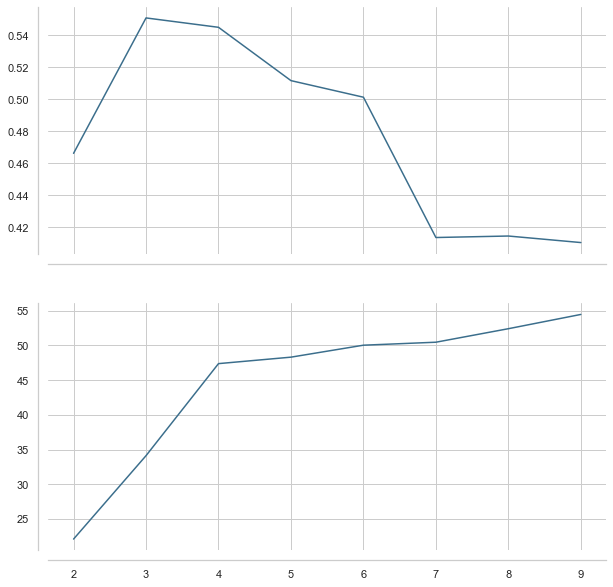

In [13]:
visualize_num_of_clusters(cgram)

**3 or 4 clusters looks optimal**. Therefore, when we use a clustering algorithm (e.g.: Kmeans), we know the number of clusters for it to create.

# Cluster the data - Kmeans

## No minimum size

In [14]:
# adjusting the data to be an array
X = np.array(arena_coords[['Lat', 'Lng']])
# applying Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# adding labels to player_gdf
arena_gdf['arena_cluster'] = kmeans.labels_

## Results of clustering the data in MinSizeKmeans

In [15]:
# prepping the data 
# savetxt('data/arena_coords.data', X, delimiter='    ')

In [16]:
# importing cluster assignments 
# MADE USING https://github.com/Behrouz-Babaki/MinSizeKmeans
## NOTE: has 4 clusters to match number of NHL divisions
f = open("data/arena_min_kmeans4.txt", 'r')
mink_clusters4 = [x[0] for x in f.readlines()]

In [17]:
# attaching to data 
arena_gdf['arena_cluster_mink4'] = mink_clusters4

In [18]:
# importing cluster assignments 
f = open("data/arena_min_kmeans3.txt", 'r')
mink_clusters3 = [x[0] for x in f.readlines()]

In [19]:
# attaching to data 
arena_gdf['arena_cluster_mink3'] = mink_clusters3

# Plotting Data

## No minimum size of cluster

<AxesSubplot:>

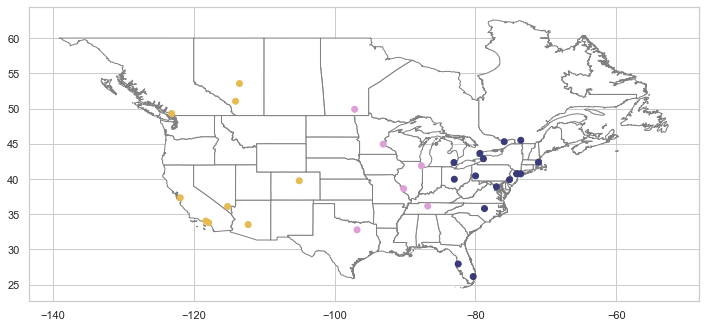

In [20]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster")

### Adding Centroids to the data

In [32]:
player_gdf_w_centroids = add_kmeans_centroids_to_gdf(arena_gdf, kmeans)

<AxesSubplot:>

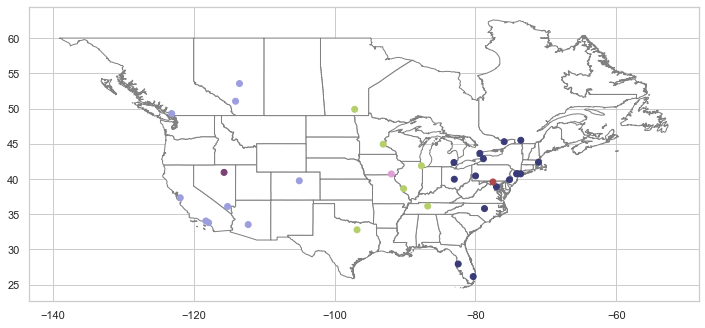

In [37]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
plot_clusters(us_can_gdf, arena_gdf_w_centroids, "arena_cluster")
# plt.title("Optimal Clustering of NHL Teams' Arenas into 3 Clusters (with centroids)")
# plt.savefig("pictures/arena_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

### How many arenas are in each cluster?

In [22]:
# clusters: 0 = east coast, 1 = west coast, 2 = central
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster.value_counts()

0    16
1     9
2     6
Name: arena_cluster, dtype: int64

## Minimum size of cluster - 3

<AxesSubplot:>

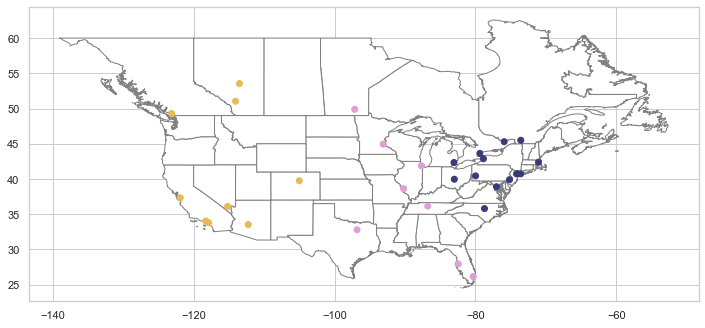

In [23]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster_mink3")

In [24]:
# number of teams in each cluster
# more teams in east coast than west and central (least)
arena_gdf.arena_cluster_mink3.value_counts()

0    14
1     9
2     8
Name: arena_cluster_mink3, dtype: int64

## Minimum size of cluster - 4

<AxesSubplot:>

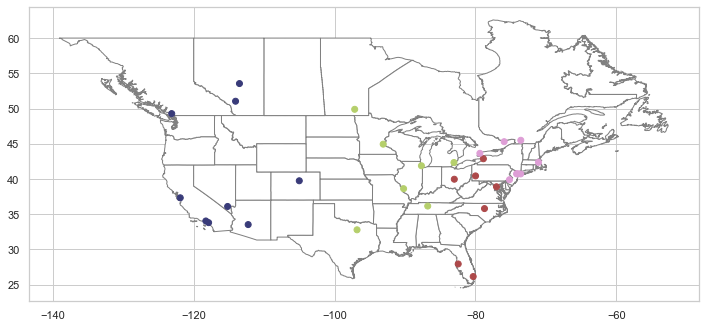

In [25]:
plot_clusters(us_can_gdf, arena_gdf, "arena_cluster_mink4")

In [26]:
# number of teams in each cluster
# more teams in west coast than west and central (least)
arena_gdf.arena_cluster_mink4.value_counts()

0    9
3    8
2    7
1    7
Name: arena_cluster_mink4, dtype: int64

# Final Notes 

I don't think it is worth writing a blog post/creating a repo to dive deep into this topic. Therefore I will leave some final thoughts and links:
- The 2021 season was certainly a wild one. We could calculate how many miles were travelled by each team in this season and see if that has any relation to gameplay. Were shift times shorter? Fewer hits? 
    - An article that goes a little more in depth with this topic can be found here: https://www.nytimes.com/2021/01/12/sports/hockey/nhl-canadian-division-travel.html
    - Here, you can see an image showing the spatial alignment of teams in 2021: https://novacapsfans.com/2020/10/20/report-nhl-realignment-by-country-region-in-store-for-2020-21-nhl-season/
    

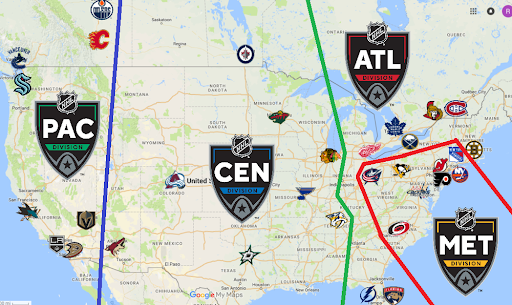

In [41]:
# - Here, you can see an image showing the spatial alignment of teams in just before the 2021 season: 
Image(filename="pictures/nhl_divisions_pre_covid.png")

There are lots of factors that go into deciding how the NHL divisions are decided: politics (see 2021 divisions), geography, established rivalries, nearest neighbors, etc. This notebook focused on one of the most important factors: distance. The further teams travel the more of a non-performing expense is spent on fuel, travel time for everyone, etc. Limiting this is very important and should be considered when deciding on future division reallignments. Using clustergrams and statistical measures, both the 3 and 4 team versions make the most sense, (geographically speaking) for the entire league.